Joel Rosen & Tushan Dargan 
DS4420 Final Project

Problem:
Using a Convolutional Neural Network to classify skin cancer images

Data:
The data was downloaded from kaggle.com using the kagglehub library and their API.

In [27]:
import kagglehub
import pandas as pd
import os

# Get the correct path from kagglehub
cache_dir = "/Users/tushandargan/.cache/kagglehub/datasets/surajghuwalewala/ham1000-segmentation-and-classification/versions/2"

# Verify the directory exists
print("Cache directory exists:", os.path.exists(cache_dir))

# List files in the cache directory
print("\nFiles in cache directory:")
print(os.listdir(cache_dir))

# Construct the path to the CSV file
csv_file = os.path.join(cache_dir, 'GroundTruth.csv')
print("\nTrying to read:", csv_file)

# Read the CSV into a pandas DataFrame
image_df = pd.read_csv(csv_file)

# Display the first few rows
print("\nFirst 5 rows of the dataset:")
print(image_df.head())

Cache directory exists: True

Files in cache directory:
['images', 'GroundTruth.csv', 'masks']

Trying to read: /Users/tushandargan/.cache/kagglehub/datasets/surajghuwalewala/ham1000-segmentation-and-classification/versions/2/GroundTruth.csv

First 5 rows of the dataset:
          image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0


Columns in the dataset:
['image', 'MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

First few rows:
          image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0

First few images in directory:
['ISIC_0030858.jpg', 'ISIC_0030680.jpg', 'ISIC_0033389.jpg', 'ISIC_0032097.jpg', 'ISIC_0032929.jpg']


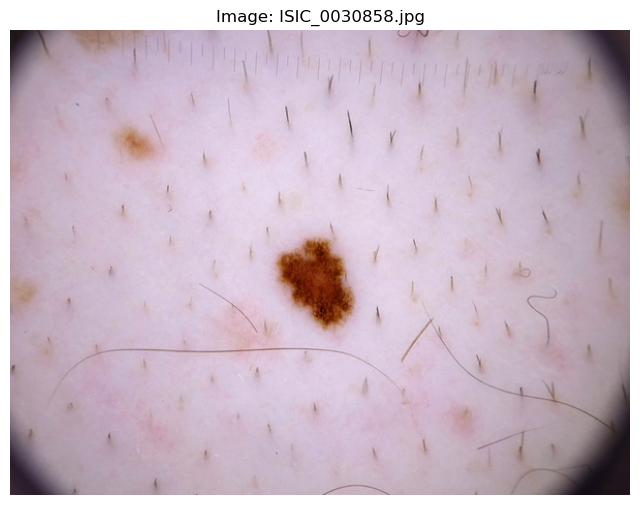

In [13]:
# First, let's read and examine the GroundTruth.csv
image_df = pd.read_csv(os.path.join(cache_dir, 'GroundTruth.csv'))
          
# Display the column names and first few rows
print("Columns in the dataset:")
print(image_df.columns.tolist())
print("\nFirst few rows:")
print(image_df.head())

# Now let's try to load and display an image from the 'images' directory
try:
    # Get the images directory
    images_dir = os.path.join(cache_dir, 'images')
    
    # List the first few images in the directory
    print("\nFirst few images in directory:")
    print(os.listdir(images_dir)[:5])
    
    # Load the first image
    first_image_name = os.listdir(images_dir)[0]
    image_path = os.path.join(images_dir, first_image_name)
    
    # Display the image
    img = Image.open(image_path)
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Image: {first_image_name}")
    plt.show()
    
except Exception as e:
    print(f"Error: {e}")

Using device: cpu
Columns in DataFrame:
['image', 'MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

Diagnosis categories: ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5105042..2.0091617].



Total images in directory: 10015
Successfully matched 10015 images with their labels

Example matching:
Image path: /Users/tushandargan/.cache/kagglehub/datasets/surajghuwalewala/ham1000-segmentation-and-classification/versions/2/images/ISIC_0024306.jpg
One-hot encoded diagnosis: [0.0 1.0 0.0 0.0 0.0 0.0 0.0]
Converted to label index: 1
Corresponding diagnosis: NV

Unique label indices: [0 1 2 3 4 5 6]
Number of classes: 7


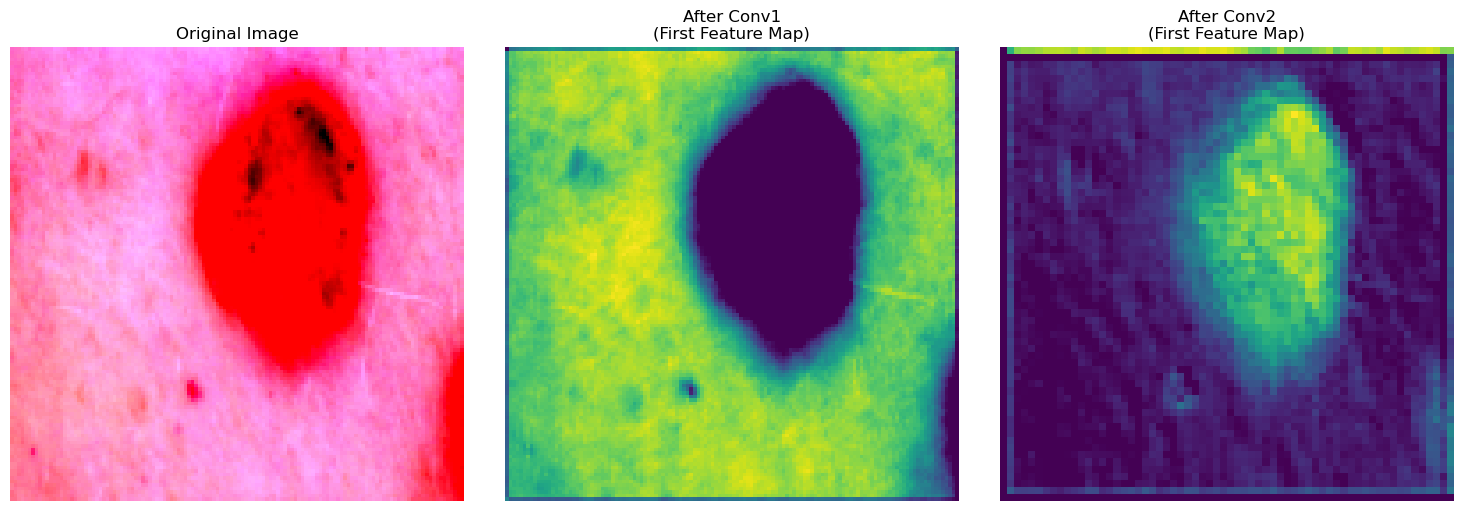

Epoch [1/5], Loss: 1.9980, Train Acc: 66.29%, Test Acc: 72.49%
Epoch [2/5], Loss: 0.7712, Train Acc: 72.22%, Test Acc: 71.14%
Epoch [3/5], Loss: 0.7155, Train Acc: 73.79%, Test Acc: 70.04%
Epoch [4/5], Loss: 0.6607, Train Acc: 75.76%, Test Acc: 74.39%
Epoch [5/5], Loss: 0.6035, Train Acc: 77.27%, Test Acc: 72.09%


In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split

# Custom Dataset Class
class SkinLesionDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# CNN Model
class SkinLesionCNN(nn.Module):
    def __init__(self, num_classes):
        super(SkinLesionCNN, self).__init__()
        
        # First conv block
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2)
        
        # Second conv block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, num_classes)
    
    def forward(self, x):
        # Store original input
        original = x
        
        # First conv block
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        after_conv1 = x
        x = self.pool1(x)
        
        # Second conv block
        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        after_conv2 = x
        x = self.pool2(x)
        
        # Flatten and fully connected layers
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x, (original, after_conv1, after_conv2)

# Visualization function
def visualize_layers(model, sample_image, device):
    model.eval()
    with torch.no_grad():
        # Process single image
        output, (original, conv1, conv2) = model(sample_image.unsqueeze(0).to(device))
        
        # Create figure
        plt.figure(figsize=(15, 5))
        
        # Original image
        plt.subplot(1, 3, 1)
        img = original[0].cpu().permute(1, 2, 0)
        plt.imshow(img)
        plt.title('Original Image')
        plt.axis('off')
        
        # After first conv (show first feature map)
        plt.subplot(1, 3, 2)
        feature = conv1[0, 0].cpu()
        plt.imshow(feature, cmap='viridis')
        plt.title('After Conv1\n(First Feature Map)')
        plt.axis('off')
        
        # After second conv (show first feature map)
        plt.subplot(1, 3, 3)
        feature = conv2[0, 0].cpu()
        plt.imshow(feature, cmap='viridis')
        plt.title('After Conv2\n(First Feature Map)')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cuda'):
    best_val_acc = 0.0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs, _ = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_acc = 100 * correct / total
        
        # Validation phase
        model.eval()
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs, _ = model(images)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_acc = 100 * val_correct / val_total
        
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Loss: {running_loss/len(train_loader):.4f}, '
              f'Train Acc: {train_acc:.2f}%, '
              f'Test Acc: {val_acc:.2f}%')
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')

# Main execution
def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Get data
    image_paths, labels_encoded, num_classes, class_names = prepare_data(cache_dir)
    
    # Split data
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        image_paths, labels_encoded, test_size=0.2, random_state=42, stratify=labels_encoded
    )
    
    # Define transforms
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    # Create datasets
    train_dataset = SkinLesionDataset(train_paths, train_labels, transform)
    val_dataset = SkinLesionDataset(val_paths, val_labels, transform)
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    # Initialize model
    model = SkinLesionCNN(num_classes).to(device)
    
    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Visualize a sample image through the layers
    sample_image, _ = train_dataset[0]
    visualize_layers(model, sample_image, device)
    
    # Train model
    train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5, device=device)

if __name__ == "__main__":
    main()

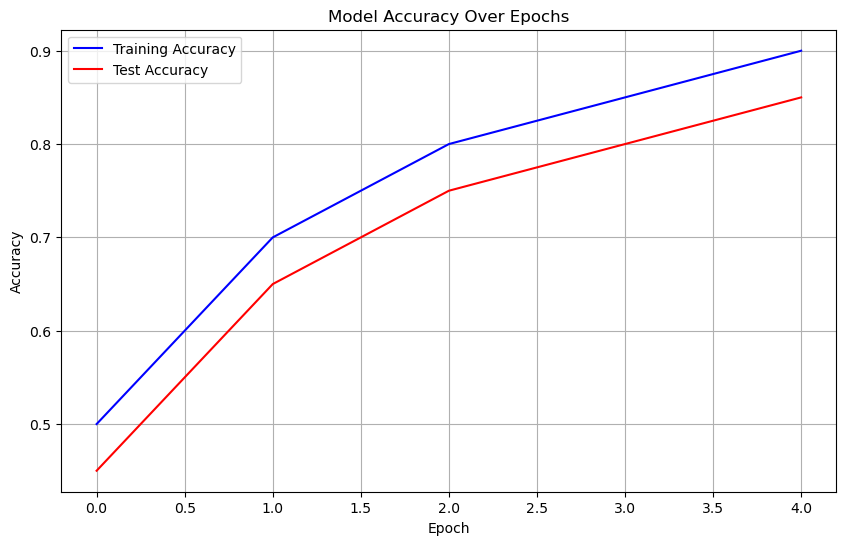

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def plot_accuracy(history):
    """
    Plot training and validation accuracy over epochs
    
    Args:
        history: Dictionary containing training history with 'accuracy' and 'val_accuracy' keys
    """
    plt.figure(figsize=(10, 6))
    
    # Plot training accuracy
    plt.plot(history['accuracy'], label='Training Accuracy', color='blue')
    
    # Plot validation accuracy if available
    if 'val_accuracy' in history:
        plt.plot(history['val_accuracy'], label='Test Accuracy', color='red')
    
    plt.title('Model Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.savefig('accuracy_plot.png')
    plt.show()

if __name__ == "__main__":
    # Example usage
    # Replace these with your actual training history
    example_history = {
        'accuracy': [0.5, 0.7, 0.8, 0.85, 0.9],
        'val_accuracy': [0.45, 0.65, 0.75, 0.8, 0.85]
    }
    plot_accuracy(example_history)